<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/miscellany/overture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A guide to making place embeddings with Overture data
[Overture Maps](https://overturemaps.org/) is open source effort to make map features readily available for web applications (as I understand it). It includes a repository of points of interest, along with cleaned up street networks. We can use these POIs to generate embeddings based on proximity.  

In [ ]:
!pip install duckdb pacmap node2vec adjustText

We need to set a bounding box to extract Overture data within; this could in principle be done with any country.

In [ ]:
import geopandas as gpd
# # Load the Natural Earth data for countries (you can adjust the resolution as needed)
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# # Filter out the United Kingdom
# uk = world[world['name'] == 'United Kingdom']
# # The UK's geometry consists of multiple polygons, we need to explode it and get the largest one (Great Britain)
# ex = uk.explode().reset_index(drop=True)
# # Assuming the largest polygon is Great Britain
# gb = ex.loc[ex.geometry.area.idxmax()]

# # Get the boundary and bounds of Great Britain
# boundary = gb.geometry.boundary
# bounds = gb.geometry.bounds

The best way to query Overture is with `duckDB`.

In [ ]:
import duckdb
import pandas as pd

# Initialize DuckDB
con = duckdb.connect(database=':memory:')

# Load the required extensions
con.execute("INSTALL httpfs;")
con.execute("INSTALL spatial;")
con.execute("LOAD httpfs;")
con.execute("LOAD spatial;")

# Your DuckDB query to fetch data
query = """
          SELECT
            id,
            updatetime,
            version,
            CAST(names AS JSON) AS names,
            CAST(categories AS JSON) AS categories,
            confidence,
            CAST(brand AS JSON) AS brand,
            CAST(addresses AS JSON) AS addresses,
            ST_AsText(ST_GeomFromWKB(geometry)) AS geometry
          FROM
            read_parquet('s3://overturemaps-us-west-2/release/2023-11-14-alpha.0/theme=places/type=*/*', hive_partitioning=1)
          WHERE
              bbox.minx > -20.390625
              AND bbox.maxx < 34.560859
              AND bbox.miny > 30.454102
              AND bbox.maxy < 62.674143
        """

# Execute the query and load data into a Pandas DataFrame
df = con.execute(query).fetchdf()
df.head()

In [ ]:
from shapely import wkt
gs = gpd.GeoSeries(df['geometry'].apply(wkt.loads))

In [ ]:
gf = gpd.GeoDataFrame(df, geometry=gs, crs="EPSG:4326")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gf.to_crs("EPSG:4326", inplace=True)

df['lon'] = gf.centroid.x
df['lat'] = gf.centroid.y

gf.to_crs("EPSG:3035", inplace=True)

df['x'] = gf.centroid.x
df['y'] = gf.centroid.y

<ipython-input-12-2c2084194944>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = gf.centroid.x
<ipython-input-12-2c2084194944>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = gf.centroid.y


In [ ]:
df.drop(['geometry'], axis=1).to_csv("drive/MyDrive/overture/eur.csv")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [ ]:
# df = pd.read_csv("drive/MyDrive/overture/gbr.csv")

In [ ]:
import json

In [ ]:
# We only need the first name...
def get_name(json_str):
    try:
        data = json.loads(json_str)
        return data['common'][0]['value'] if data['common'] else None
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None

# Apply the function to the DataFrame
df['extracted_name'] = df['names'].apply(get_name)

In [ ]:
amenities = df[df.categories.str.contains("restaurant|cafe|bar|shop|pub|hotel")]

It uses data from OpenStreetMap (among other sources), so the names need a lot of cleaning.

In [ ]:
amenities['name'] = amenities.extracted_name.str.replace(" UK & Ireland", "")
amenities['name'] = amenities.name.str.replace(" GB", "")
amenities['name'] = amenities.name.str.replace(" UK", "")
amenities['name'] = amenities.name.str.replace(" Great Britain", "")
amenities['name'] = amenities.name.str.replace("Tesco [A-Z].*", "Tesco")
amenities['name'] = amenities.name.str.replace("Sainsbury's [A-Z].*", "Sainsbury's")
amenities['name'] = amenities.name.str.replace("Pizza Hut [A-Z].*", "Pizza Hut")
amenities['name'] = amenities.name.str.lower()

<ipython-input-22-f60b4219c81e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities['name'] = amenities.extracted_name.str.replace(" UK & Ireland", "")
<ipython-input-22-f60b4219c81e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amenities['name'] = amenities.name.str.replace(" GB", "")
<ipython-input-22-f60b4219c81e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
top_n = amenities.name.value_counts()
top_n = top_n[top_n > 50]

In [ ]:
chains = amenities[amenities.name.isin(top_n.index)]

In [ ]:
chains.shape[0]

229689

We will build graph embeddings from proximity: if 2 POIs are nearby, we will link them.

In [ ]:
# Step 1: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(chains[['name']], geometry=gpd.points_from_xy(chains.x, chains.y))

# Step 2: Create 250m buffers
gdf['geometry'] = gdf.geometry.buffer(250)

# Step 3: Spatial join - this finds which points are within 250m of each other
joined = gpd.sjoin(gdf, gdf, how='inner', predicate='intersects')

# Step 4: Count co-occurrences - but exclude self-join
edge_counts = joined[joined['name_left'] != joined['name_right']].groupby(['name_left', 'name_right']).size().reset_index(name='count')
edge_counts.head()

,name_left,name_right,count
0,1.day,4f,1
1,1.day,art cafe,1
2,1.day,bar italia,1
3,1.day,bella napoli,1
4,1.day,billa,3


In [ ]:
# Step 1: Sort names within each pair
edge_counts['sorted_pair'] = edge_counts.apply(lambda row: tuple(sorted([row['name_left'], row['name_right']])), axis=1)

# Step 2: Remove duplicates
edge_counts_unique = edge_counts.drop_duplicates(subset='sorted_pair')

# Drop the temporary 'sorted_pair' column and reset index
edge_counts_unique = edge_counts_unique.drop(columns='sorted_pair').reset_index(drop=True)

In [ ]:
import networkx as nx

In [ ]:
G = nx.from_pandas_edgelist(edge_counts_unique, 'name_left', 'name_right', ['count'])

In [ ]:
from node2vec import Node2Vec

In [ ]:
n2v = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/1354 [00:00<?, ?it/s]

In [ ]:
model = n2v.fit(window=10, min_count=1, batch_words=4)

In [ ]:
embed = model.wv

In [ ]:
pcmp = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0).fit_transform(embed.vectors, init="pca")

In [ ]:
# from sklearn.manifold import TSNE
# emb2d = TSNE(n_components=2).fit_transform(embed.vectors)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from adjustText import adjust_text

In [ ]:
labels = top_n.iloc[0:100]
labels = labels.index

In [ ]:
# We only need to first name...
def get_category(json_str):
    try:
        data = json.loads(json_str)
        return data['main'] if data['main'] else None
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None

In [ ]:
chains['category'] = chains.categories.apply(get_category)
chains['category'] = chains.category.str.replace(".*_", "")
categories = chains.groupby(["name", "category"], as_index=False).size().sort_values("size", ascending=False).groupby("name", as_index=False).first()
categories = categories[['name', 'category']].set_index("name")

In [ ]:
import colorcet as cc

In [ ]:
colors = dict([(k, cc.glasbey_dark[i])for i, k in enumerate(categories.category.unique())])

crosswalk = categories.to_dict()
crosswalk = crosswalk.get('category')

crosswalk = dict([(i[0], [i[1], colors.get(i[1])]) for i in crosswalk.items()])

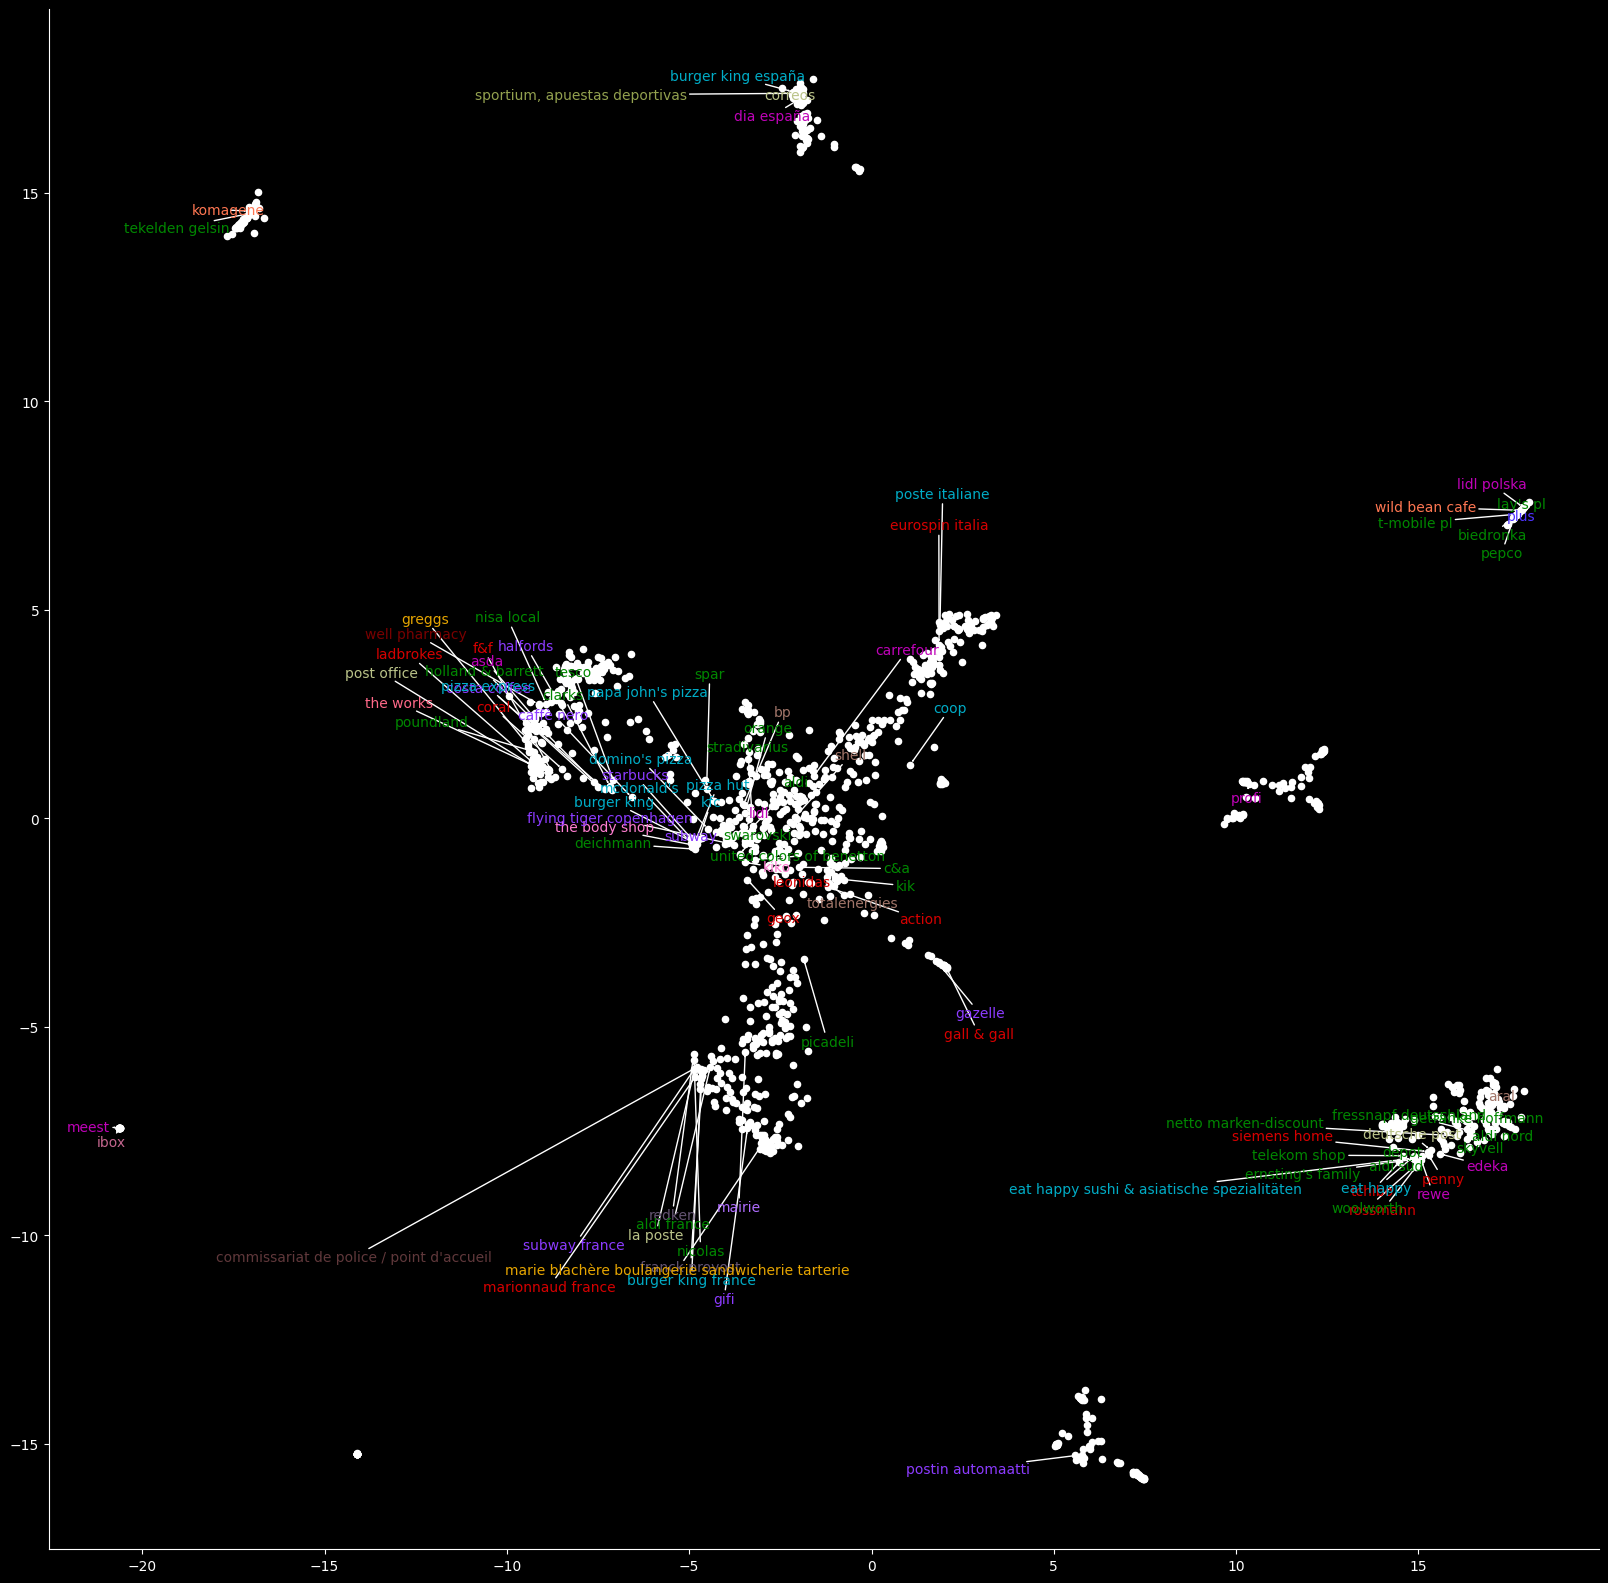

In [ ]:
# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(20, 20), facecolor='#000000')

# Set the style
plt.style.use('dark_background')

# Scatter plot with smaller white points
ax.scatter(pcmp[:, 0], pcmp[:, 1], color='white', s=20)  # s is the size of the marker

# Customizing the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Setting axis labels
ax.set_xlabel('', fontsize=12, fontweight='bold', color='white')
ax.set_ylabel('', fontsize=12, fontweight='bold', color='white')

# Adding brand labels with adjustText
texts = []
for i, brand in enumerate(embed.index_to_key):
    if brand in labels:
      col = crosswalk.get(brand)
      texts.append(ax.text(pcmp[i, 0], pcmp[i, 1], brand, color=col[1], ha='right', va='top'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='white'))

plt.show()